# NTM - dataframe calculator
### Enrico Gavagnin

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import community
import statistics
import scipy.stats as stats
from os import listdir
from datetime import datetime, date, timedelta
import pickle

In [2]:
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in listdir(working_dir) if s[15:17] == '.m'])

## Property calculator (fixed time-window)

In [3]:
# function to compute netowrk properties
def G_prop(G, start, time_win, max_gap, name):
    
    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(Gcc[0])
    
    # Best partition Louvian Method
    best_partition = community.best_partition(G, weight='weight', randomize=False)
    best_partition_CC = community.best_partition(GC, weight='weight', randomize=False)
    return {'rep': int(name[8:10]),
            'exp': name[11:15],
            'start': fm.Time.ToDateTime(start), 
            'time_win': time_win, 
            'max_gap': max_gap,
            'GC': GC.number_of_nodes(),
            'ants': G.number_of_nodes(),
            'partition': np.max(list(best_partition_CC.values())) + 1,
            'MOD': community.modularity(best_partition, G),
            'cMOD': community.modularity(best_partition_CC, GC),
            'DEN': nx.density(G), 
            'wDEN': nx.adjacency_matrix(G).sum() / (G.number_of_nodes() * (G.number_of_nodes() - 1) * time_win),  # weighted density = sum all weights /(|V|*(|V|-1)/2 * time_win)
            'DIA': nx.diameter(GC),
            'wDIA': nx.diameter(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'RAD': nx.radius(GC),
            'wRAD': nx.radius(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'DEH': np.std([G.degree(n) for n in G.nodes()]),
            'cDEH': np.std([GC.degree(n) for n in GC.nodes()]),
            'wDEH': np.std(nx.adjacency_matrix(G).sum(axis=0)), # strength heterogeneity
            'cwDEH': np.std(nx.adjacency_matrix(GC).sum(axis=0)), # strength heterogeneity
            'CLS': np.mean([c for c in nx.clustering(G, weight='weight').values()]) 
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),fm.Time.Now(),1,1,myrm_list[0]).keys())

In [4]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones):
                
            # OPT1
            # WEIGHTS: cumulative interaction time
            #adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (TimeToFrame[fm.Time.ToTimestamp(i.End)] - TimeToFrame[fm.Time.ToTimestamp(i.Start)]) * 1 / frm_rate
        
            # OPT2
            # WEIGHTS: number of interactions
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
                    

    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # network build
    G = nx.Graph(adj_mat)

    # store inverse of weights
    nx.set_edge_attributes(G, 
                           {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
                           'inv_weight')
    return G



In [5]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# maximum gap (s) for interaction computation
for max_gap in [10]:

    print(max_gap)
    
    # minimum cumulative interaction duration (s)
    min_cum_duration = 0 


    ## ============================ 


    for myrm_file in myrm_list[20:]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)

        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)


        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")


        # ======== 12H window ========
        #print('12h slot')
        # cumulative time window (s)
        time_win = 60 * 60 * 12

        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  #to do: double check time shift
        end = start.Add(fm.Duration(time_win * 10**9))

        # Compute network
        #G = compute_G(exp, start, end, min_cum_duration, frm_rate)

        # Compute properties
        #prop_df = prop_df.append(G_prop(G, start, time_win, max_gap, myrm_file), ignore_index=True)

        # ======== 1H window ========
        time_win = 60 * 60 * 1
        for tw in range(12):
            print('1h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
            
            
        
        # ======== 2H window ========
        time_win = 60 * 60 * 2
        for tw in range(6):
            #print('2h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)

        # ======== 4H window ========
        time_win = 60 * 60 * 4
        for tw in range(3):
            print('4h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
            
         # ======== 6H window ========
        time_win = 60 * 60 * 6
        for tw in range(2):
            print('6h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)



# Save
a_file = open("data/prop_data_6_4_2_1_ni_NEST.pkl", "wb")
pickle.dump(prop_df, a_file)
a_file.close()

prop_df

10
EG_NTM_s13_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s13_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s14_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s14_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s15_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s15_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s16_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s16_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s17_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s17_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s18_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s18_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s19_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s19_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s20_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s20_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s21_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s21_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s22_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s22_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s23_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s23_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s24_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s24_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s25_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s25_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s26_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s26_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s27_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s27_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s28_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s28_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s29_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s29_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s30_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s30_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s31_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s31_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s32_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s32_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s33_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s33_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s34_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s34_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s35_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s35_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s36_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s36_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s37_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s37_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s38_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s38_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s39_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s39_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s40_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s40_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s42_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s42_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s43_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s43_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s44_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s44_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s45_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s45_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s46_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s46_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s47_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s47_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s48_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s48_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s49_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s49_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s50_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s50_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s51_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s51_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s52_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s52_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s53_DIAa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s53_DIAb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s54_MODa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s54_MODb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s55_DEHa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s55_DEHb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s56_DENa.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s56_DENb.myrmidon
1h slot 1


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 2


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 3


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 4


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 5


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 6


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 7


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 8


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 9


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 10


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 11


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


1h slot 12


/tmp/ipykernel_32544/1250802779.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_32544/1250802779.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, ti

4h slot 1


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 2


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


4h slot 3


/tmp/ipykernel_32544/1250802779.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 1


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


6h slot 2


/tmp/ipykernel_32544/1250802779.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


,rep,exp,start,time_win,max_gap,GC,ants,partition,MOD,cMOD,...,wDEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,3600,10,151,177,6,0.263711,0.266534,...,0.00026,3,2.20202,2,1.161317,33.888839,29.845601,126.960443,115.764304,0.033145
1,13,DEHa,2021-09-12 10:00:00,3600,10,144,177,6,0.26339,0.258668,...,0.000217,4,2.339286,2,1.190476,31.562412,26.939089,117.144284,107.497796,0.030286
2,13,DEHa,2021-09-12 11:00:00,3600,10,147,177,6,0.195701,0.197361,...,0.000301,4,2.333333,2,1.166667,36.854597,30.674501,155.990693,142.623339,0.032902
3,13,DEHa,2021-09-12 12:00:00,3600,10,135,177,5,0.272973,0.271347,...,0.000185,4,3.214286,2,2.0,28.633435,24.312736,112.915311,105.48876,0.042335
4,13,DEHa,2021-09-12 13:00:00,3600,10,137,177,7,0.164067,0.160069,...,0.000273,3,2.212888,2,1.142857,35.837169,27.33305,149.093967,132.012389,0.052616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,56,DENb,2021-12-20 09:00:00,14400,10,167,172,4,0.138351,0.137717,...,0.000359,4,2.55,2,1.5,39.65819,34.663966,425.079349,402.565361,0.054525
1974,56,DENb,2021-12-20 13:00:00,14400,10,163,172,7,0.141859,0.14168,...,0.000345,3,2.150517,2,1.120952,41.6158,33.463822,439.921541,402.815919,0.05005
1975,56,DENb,2021-12-20 17:00:00,14400,10,168,172,5,0.156485,0.151195,...,0.000335,4,3.127496,2,2.0,39.266968,35.520155,413.269796,397.793408,0.054442
1976,56,DENb,2021-12-20 09:00:00,21600,10,170,172,5,0.138825,0.136562,...,0.000349,4,3.562745,2,2.0,39.136738,36.83625,621.859152,609.458769,0.06277


### Zoning Test

In [ ]:
myrm_file = myrm_list[-2]

min_cum_duration = 0
frm_rate = 6
max_gap = 10


exp = fm.Experiment.Open(working_dir + myrm_file)
start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
             timedelta(days = -1)).strftime("%Y-%m-%d")

# ======== 12H window ========

# cumulative time window (s)
time_win = 60 * 60 * 0.05

for t in range(4):
    start_g = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  #to do: double check time shift
    start = start_g.Add(fm.Duration(t * time_win * 10**9))
    end = start.Add(fm.Duration(time_win * 10**9))
    

    N_ants = len(exp.Ants)

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    #TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}
    Q_int = fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(10*10**9),
                                            reportFullTrajectories= False)
    #G = compute_G(exp, start, end, min_cum_duration, frm_rate)


    # compute connencted components
    #Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    #GC = G.subgraph(Gcc[0])
    
    #plt.figure()
    #nx.draw(GC)
    #plt.title(GC.number_of_nodes())
    l1 = []
    for a in Q_int[1]:
        if not(2 in a.Trajectories[1].Zones):
            l1.append(a.Trajectories[1].Mean[:2])
            
            
    
    l1 = np.array(l1)
    plt.scatter(l1[:,0],l1[:,1])
    

# Propagation time expansion coefficient calculator 

In [98]:
# function to compute propagation times expansion coefficients
#def PTEC(exp, start, end, frm_rate):

start = s
end = e

# Number of ants
N_ants = len(exp.Ants)    

focal_ant = 2

prop_tree = [[{1}],[0]]

# # initialise adj-matrix
first_contact_mat = np.ones((N_ants, N_ants)) * np.inf

# # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

# # # Populate network
for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                        reportFullTrajectories= False)[1]:
    # Focus on Nest zone (id=1)
    if (1 in i.Trajectories[1].Zones) & (len(prop_tree[0][-1].intersection(set(i.IDs))) == 1) & (TimeToFrame[fm.Time.ToTimestamp(i.Start)] >= prop_tree[1][-1]):
            prop_tree[0].append(prop_tree[0][-1].union(set(i.IDs)))
            prop_tree[1].append(TimeToFrame[fm.Time.ToTimestamp(i.Start)])
        
# # interaction filtering (remove weak connections)
# adj_mat[adj_mat <  min_cum_duration] = 0

# # network build
# G = nx.Graph(adj_mat)

# # store inverse of weights
# nx.set_edge_attributes(G, 
#                        {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
#                        'inv_weight')
# return G

prop_tree

[[{1},
  {1, 156},
  {1, 4, 156},
  {1, 4, 90, 156},
  {1, 4, 90, 107, 156},
  {1, 4, 55, 90, 107, 156},
  {1, 4, 55, 77, 90, 107, 156},
  {1, 4, 36, 55, 77, 90, 107, 156},
  {1, 4, 36, 55, 77, 90, 107, 110, 156},
  {1, 4, 36, 55, 77, 90, 107, 110, 156, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 156, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 156, 165, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 116, 156, 165, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 116, 156, 161, 165, 172},
  {1, 4, 18, 36, 55, 64, 77, 90, 107, 110, 116, 156, 161, 165, 172},
  {1, 4, 18, 36, 55, 64, 77, 90, 107, 108, 110, 116, 156, 161, 165, 172},
  {1, 4, 18, 36, 55, 64, 77, 90, 107, 108, 110, 116, 156, 161, 164, 165, 172},
  {1,
   4,
   18,
   36,
   55,
   64,
   77,
   90,
   107,
   108,
   110,
   116,
   133,
   156,
   161,
   164,
   165,
   172},
  {1,
   4,
   18,
   36,
   55,
   64,
   77,
   90,
   107,
   108,
   110,
   116,
   133,
   149,
   156,
   161,
   164,
   165,
   172},
  {1,
   4

/tmp/ipykernel_4632/397941628.py:48: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(y[1:]*np.diff(x)))


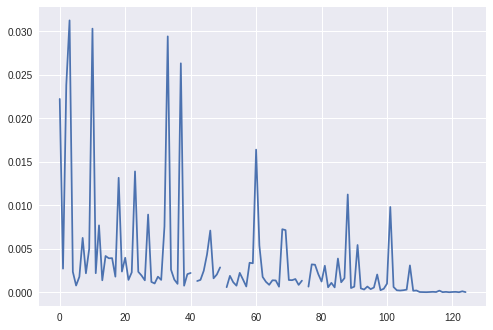

In [97]:
import itertools
from datetime import timedelta
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("seaborn")
import pandas as pd
from sklearn.linear_model import LinearRegression

def linear_regression(x, y):
    """ Find the coefficients of the linear function  y=ax + b,  
        using a linear regression.
    """
    X = x.reshape(-1, 1) 
    reg = LinearRegression(fit_intercept=True, normalize=True)
    _ = reg.fit(X, y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_hat = a * x + b
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    _ = plt.plot(x, y, 'o')
    _ = plt.plot(x, y_hat, '-', label='Linear regression')
    _ = ax.set_xlabel('D(t)')
    _ = ax.set_ylabel('Ratios of slopes to function values')
    _ = ax.legend()
    return a, b

def plot_t0(a, b, country, death_min=0, death_max=None, t0=0):
    """ Find a value of t0 such that the logistic curve is as close 
        as possible to the data on the given interval.
    """
    k = b
    L = -b / a
    country = country[country > death_min]
    if death_max is not None:
        country = country[country < death_max]
    logis = L / (1. + np.exp(-k * (np.arange(len(country)) - t0)))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    _ = plt.plot(logis, 'o')
    _ = plt.plot(country.values, 'd')
    return L, k


x = np.array(prop_tree[1][1:])
y = np.array(range(len(x)))

plt.plot(1/(y[1:]*np.diff(x)))




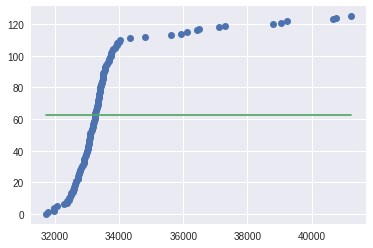

array([54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54.])

In [101]:
import scipy.optimize as opt

x = np.array(prop_tree[1][1:])
y = np.array(range(len(x)))

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b
popt, pcov = opt.curve_fit(f, x, y, method="trf")
y_fit = f(x, *popt)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')
plt.show()

#plt.plot(x, y)
#plt.plot(x, logistic(x))
#plt.yscale('log')
#plt.xlim([prop_tree[1][1],34000])
logistic(x)

# Connectivity plots vs time-window size

In [ ]:
# Time vs Connectivity

def compute_Gcc(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))
    
    Gcc = [[sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True)],
           [0]]

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones) & (adj_mat[i.IDs[0]-1, i.IDs[1]-1] == 0):
            
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] = 1           
         
            if i.Start.After(start.Add(fm.Duration((Gcc[1][-1] + 1) * 10**9))):
    
                Gcc[0].append(sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True))
                Gcc[1].append(Gcc[1][-1] + 1)
                    
    # network build
    return   Gcc



## ============= LOOP =============== 

Gcc_df = pd.DataFrame(columns=['rep', 'exp', 'Gcc'])
max_gap = 10
for myrm_file in myrm_list[20:]:

    if int(myrm_file[8:10])==41: 
        continue

    print(myrm_file)

    # Open experiment file
    exp = fm.Experiment.Open(working_dir + myrm_file)

    ## ------ Time window ------ 
    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                 timedelta(days = -1)).strftime("%Y-%m-%d")

    start_time = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    
    Gcc = compute_Gcc(exp,start_time,start_time.Add(fm.Duration(12 * 60 * 60 * 10**9)))
    
    Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)

    
# Save
a_file = open("data/Gcc_NEST.pkl", "wb")
pickle.dump(Gcc_df, a_file)
a_file.close()

Gcc_df

EG_NTM_s13_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s13_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s50_DIAa.myrmidon


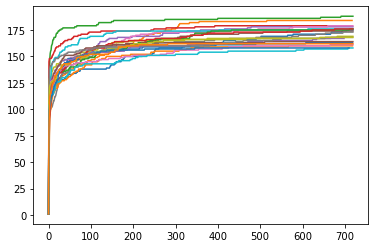

In [28]:
Gcc_df = pd.read_pickle('data/Gcc_NEST.pkl')
Gcc_df = Gcc_df[Gcc_df.rep != 20]

for rep in Gcc_df.Gcc:
   plt.plot([len(cc[0]) for cc in rep[0]])
   #plt.xlim([0,10])

